In [1]:
import ROOT
from ag import *
from scipy.stats import pearsonr
from iminuit import Minuit, cost
from scipy import stats
from math import erfc

Welcome to JupyROOT 6.30/06


In [2]:
def load(path):
    file     = ROOT.TFile.Open(path)
    tree     = file.Data_F
    time    = []
    channel = []
    for i in range(tree.GetEntries()):
        tree.GetEntry(i)
        if time :
            assert tree.Timestamp >= time[-1]
        time.append(tree.Timestamp / 1e12)
        channel.append(tree.Channel)
    time    = nn.array(time)
    channel = nn.array(channel)
    return time, channel

In [3]:
%%time
time2, channel2 = load('efficiency_test/sec1_double_eff_test/FILTERED/SDataF_sec1_double_eff_test.root')
time3, channel3 = load('efficiency_test/sec1_triple_eff_test/FILTERED/SDataF_sec1_triple_eff_test.root')

CPU times: user 1.9 s, sys: 67.1 ms, total: 1.97 s
Wall time: 2.31 s


In [4]:
min_time = 500 # the first events are ch0 only, so skipping those

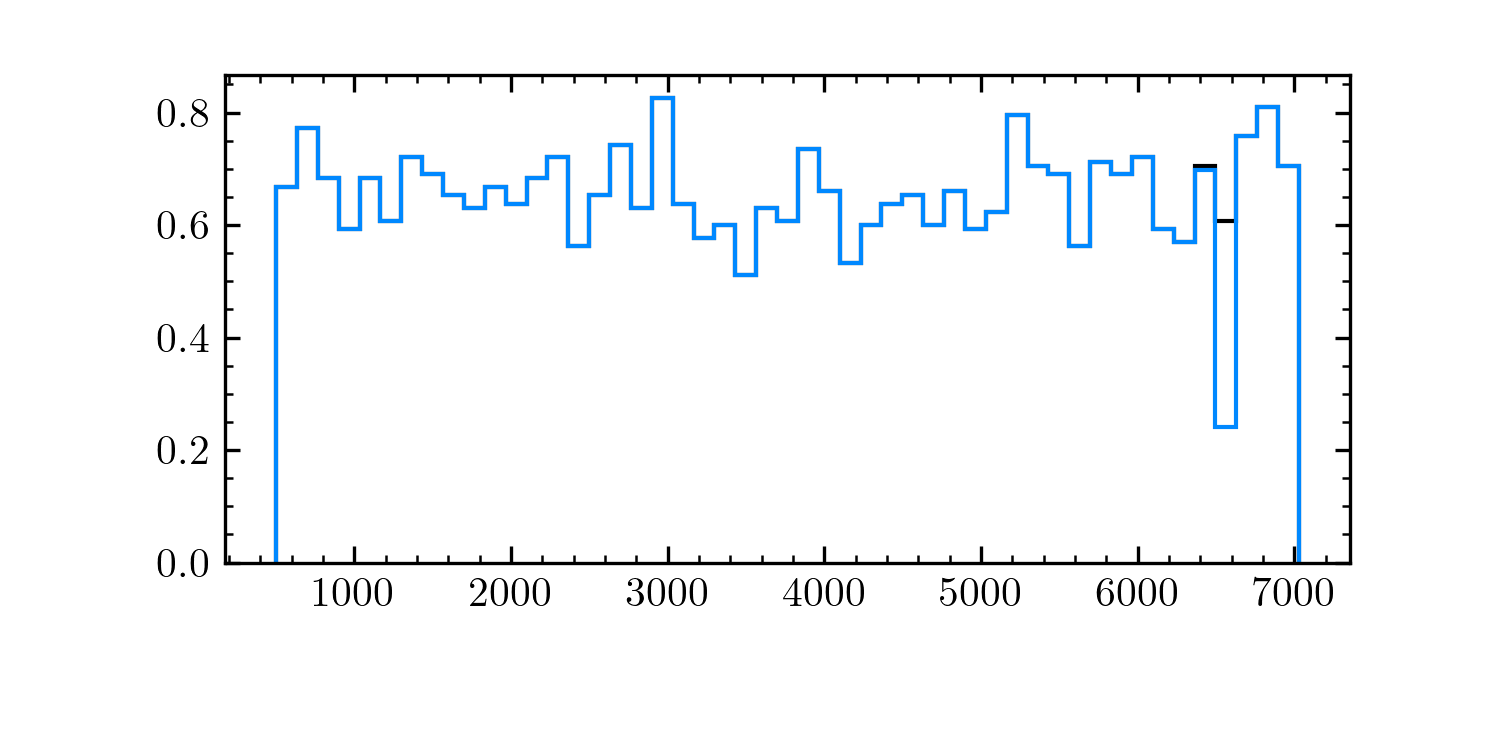

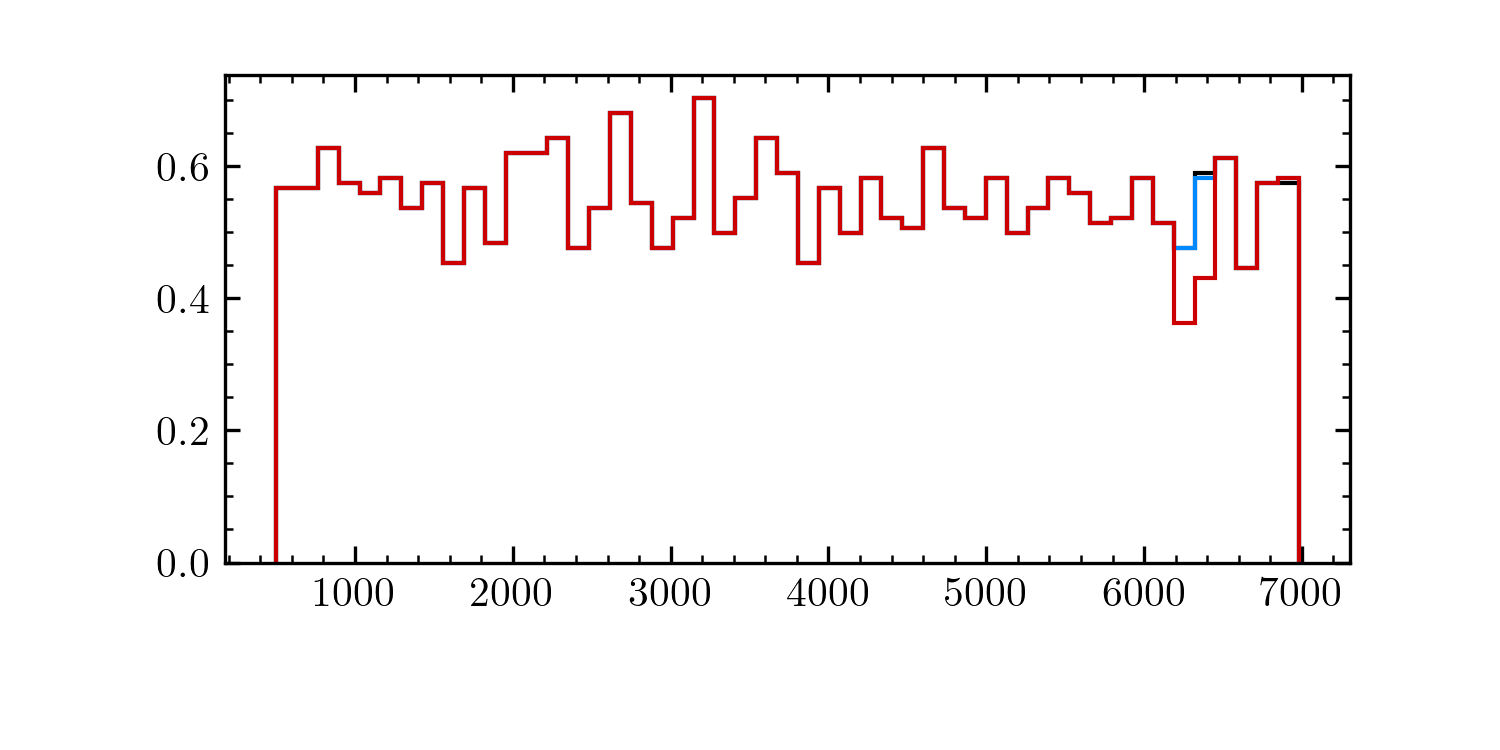

In [5]:
def get_rate(time, channel):
    values = []
    errors = []
    for c in set(channel):
        select = AND(channel == c, time > min_time)
        bins = nn.linspace(min_time, nn.max(time))
        pp.hist(time[select], bins=bins, weights=nn.ones_like(time[select])/nn.mean(nn.diff(bins)),
            histtype='step', ls='solid')
        nevents = nn.sum(select)
        maxtime = nn.max(time[select]) - min_time
        values.append(nevents/maxtime)
        errors.append(nn.sqrt(nevents)/maxtime)
    pp.show()
    return values, errors
values2,errors2 = get_rate(time2, channel2)
values3,errors3 = get_rate(time3, channel3)

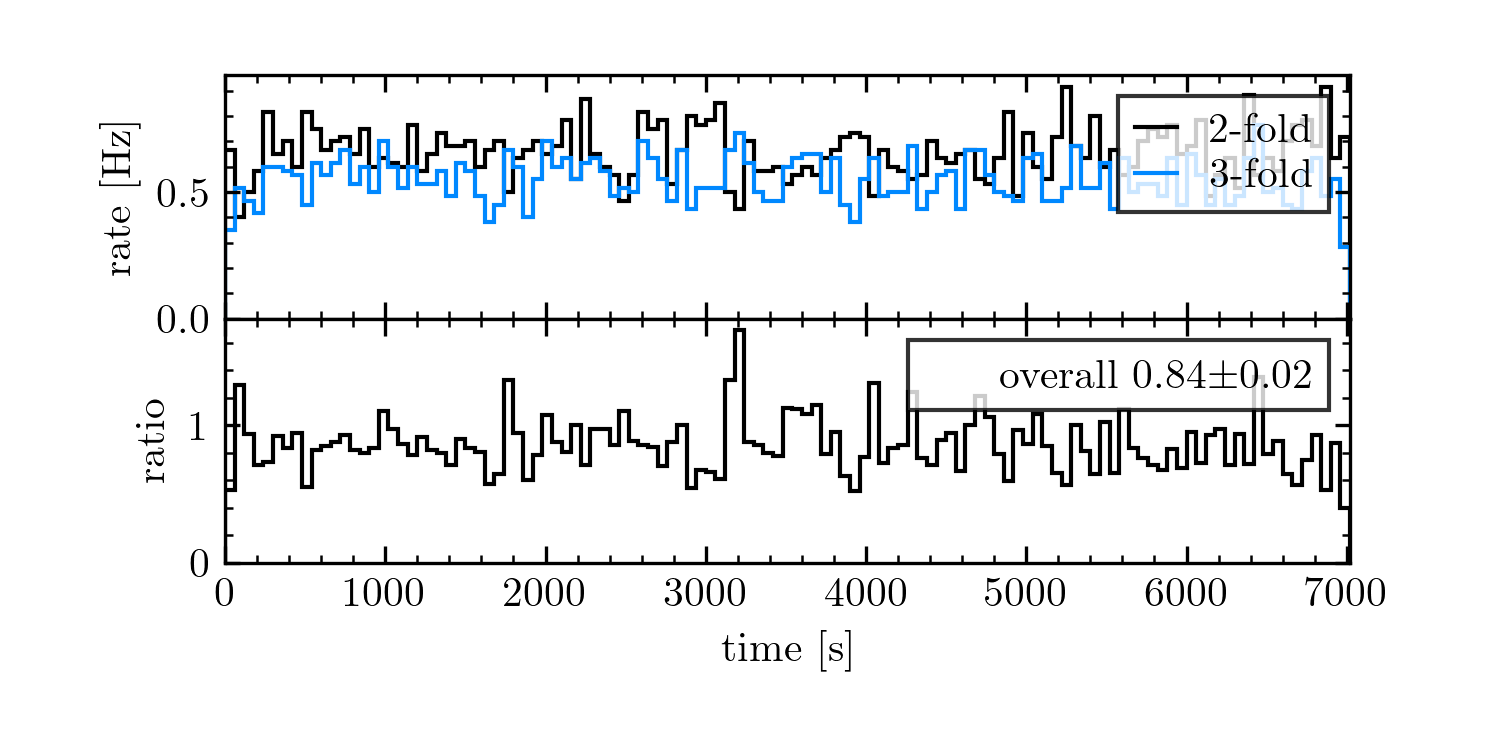

In [6]:
max_time = max(nn.max(time2), nn.max(time3))
bins = nn.linspace(0, max_time, 20)
bins = nn.arange(0, max_time, 60)

select = AND(channel2 == 0)
v2,_ = nn.histogram(time2[select], bins=bins)
v2 = v2 / nn.mean(nn.diff(bins))

select = AND(channel3 == 0)
v3,_ = nn.histogram(time3[select], bins=bins)
v3 = v3 / nn.mean(nn.diff(bins))

fig, axs = pp.subplots(nrows=2, ncols=1, sharex=True)
axs[0].stairs(v2, bins, label='2-fold')
axs[0].stairs(v3, bins, label='3-fold')
axs[0].set_ylabel('rate [Hz]')
#axs[0].set_ylim(0.35, 0.85)
axs[0].legend(framealpha=0.8)
axs[1].stairs(v3/v2, bins)
axs[1].set_ylabel('ratio')
axs[1].set_xlabel('time [s]')
axs[1].set_xlim(min(bins), max(bins))
#axs[1].set_ylim(0.5, 1.1)

v2, e2 = values2[0], errors2[0]
v3, e3 = values3[0], errors3[0]
ratio = v3 / v2
err   = ratio * nn.sqrt((e2/v2)**2 + (e3/v3)**2)
axs[1].plot([],[],label='overall %.2f$\\pm$%.2f' % (ratio, err), color='w')
axs[1].legend(framealpha=0.8)

pp.subplots_adjust(hspace=0)
pp.show()